# Use pure pytorch tensor datastructure to build the Neural Network - No Autodifferenciation

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
from sklearn.metrics import mean_squared_error
import numpy as np
import torch

# Utility function for 3D plot
We will be using this 3D plot in order to plot the real values of y with respect to the predicted values of y. This will help us in understading how those two values are related and how they change with or without activation function.

In [22]:
def plot_3d(comp, graph_title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(graph_title)
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [23]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed instead of np.random.seed(2232) use Torch
torch.manual_seed(2232)

# Generating X with 3 dimentions
X = torch.rand((n, inputs_dimensions)).uniform_(-1,1)
print('Sample Value for X:' + str(X[:3]))

# Generating the value of the y_true
weights_true = np.array([[4., 3., -2.],[-1., -1., 3.]])
bias_true = np.array([[1],[1]])

y_true = (9. * X ** 2.) @ weights_true.T + X @ weights_true.T + bias_true.T

print('Sample Value for y:'+ str(y_true[:3]))


Sample Value for X:tensor([[ 0.6869, -0.6098,  0.8382],
        [ 0.2776, -0.7326,  0.4000],
        [ 0.0560,  0.3198, -0.9075]])
Sample Value for y:tensor([[14.6238, 14.8144],
        [13.4994,  1.4501],
        [-7.9519, 19.1902]], dtype=torch.float64)


# Plotting the data in a 3-Dimentional Plane

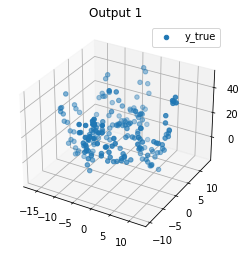

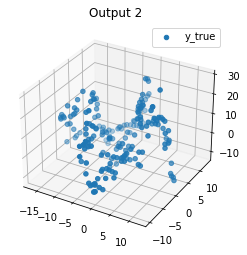

In [24]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [25]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print(inputs)
print(outputs)

3
2


# Defining activation function

In [26]:
class Relu:
    def __init__(self):
        self.input = torch.tensor([])

    def forward(self, input):
        self.input = input
        self.output = torch.clamp(self.input, min=0)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return (self.input > 0) * upstream_gradient
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

# Defining Mean Squared Error

In [27]:
# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Defining various Layers of Neural Network

In [28]:
class Layer:
    def __init__(self, num_input_nodes=1, num_output_nodes=1, activation=None):
        self.num_input_nodes = num_input_nodes
        self.num_output_nodes = num_output_nodes
        
        # Random assignment of Weights and Bias
        self.weights = torch.rand(num_input_nodes, num_output_nodes).uniform_(-1,1)
        self.bias = torch.rand((1))
        self.X = torch.zeros([num_input_nodes])
        
        # Activation Function 
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X
        self.Z = X @ self.weights + self.bias
        
        # Activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    # Backpropagation
    def backward(self, upstream_gradient):
        curr_upstream_gradient = upstream_gradient
        if self.activation != None: # Back Propogation
            curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

        # Gradient weights
        self.dJdW = self.X.T.float() @ curr_upstream_gradient.float()
        
        # Bias Calculation
        self.dJdb = curr_upstream_gradient.sum()
        # Calculate upstream
        self.dJdX = curr_upstream_gradient.float() @ self.weights.T.float()
        return self.dJdX

    # Update weight and bias
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

# Defining the Neural Net Model

In [29]:
class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]

        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        # Print network architecture for debugging
        print('Neural Net Architecture:')
        for i, layer in enumerate(self.layers):
            print('=== Layer {} ==='.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs
        for l in self.layers:
          curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true):
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred))
        loss_gradient = mse.backward()
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(learning_rate)

    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Training with Activation function RELU
With RELU as activation function we see that there is a considerable decrease in the error as the training proceeds.

In [30]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
=== Layer 1 ===
=== Layer 2 ===

Error:  252.2305800180066
Error:  241.57835546496136
Error:  226.30897455788454
Error:  198.7498535983776
Error:  153.89048864967654
Error:  151.79880345877967
Error:  169.59298543166227
Error:  144.0691561894878
Error:  146.5568304654796
Error:  147.74263213190054
Error:  158.50091123353874
Error:  145.73773068239498
Error:  152.2628898053284
Error:  146.03136139492804
Error:  153.09830977840852
Error:  143.9973549035484
Error:  148.1466198486592
Error:  143.21114739409077
Error:  146.42539492999813
Error:  142.0349809803805
Error:  144.0913888198788
Error:  140.62923152555462
Error:  141.670253873549
Error:  139.1842336727408
Error:  139.44839429316275
Error:  137.48017295936006
Error:  137.13320137613593
Error:  135.81484621676702
Error:  135.14307012662636
Error:  133.86234002203113
Error:  132.70177989104684
Error:  131.22355184084554
Error:  129.77859618335577
Error:  128.08220195280663
Error:  126.44211737

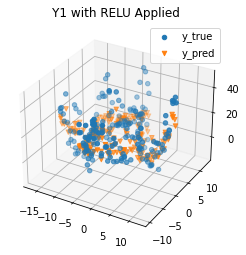

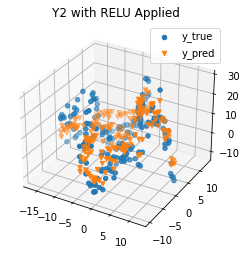

In [31]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU Applied', X, y_true[:,1], y_pred[:,1])

# Training without Activation function RELU
We see that without the activation function the error does not decrease as seen in the above example.

In [32]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Neural Net Architecture:
=== Layer 0 ===
=== Layer 1 ===
=== Layer 2 ===

Error:  237.86887961866765
Error:  196.3160164673743
Error:  146.54454068757934
Error:  144.56426221717877
Error:  146.71313590577654
Error:  161.58878897058077
Error:  169.37375588130183
Error:  228.43442713108328
Error:  202.6377821228711
Error:  152.45966795800925
Error:  159.96422700218187
Error:  203.72895279825735
Error:  159.40531794363565
Error:  154.53758622730777
Error:  187.34146496506324
Error:  143.32398581598866
Error:  146.42274563587176
Error:  160.62776855553318
Error:  150.0609474704221
Error:  172.75134142008258
Error:  141.7884359613216
Error:  143.81978459204663
Error:  147.1338651431514
Error:  162.94261647378693
Error:  145.8176744086876
Error:  158.31253519224651
Error:  147.84804652837505
Error:  164.6929537564876
Error:  143.333938909547
Error:  149.67973553299376
Error:  149.39968294946468
Error:  168.67557501621744
Error:  140.9311002224798
Error:  141.84235926612234
Error:  143.300149

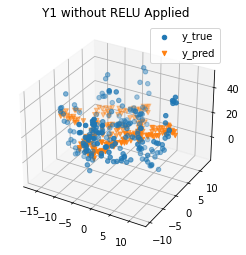

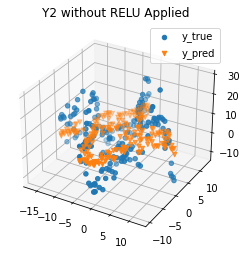

In [33]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 without RELU Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 without RELU Applied', X, y_true[:,1], y_pred[:,1])